In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

sns.set(style="whitegrid")
BASE_PATH = Path("../simulation_results/reduced")

In [2]:
def prepare_data():
    csv_files = list(BASE_PATH.rglob("*.csv"))
    dataframes = []

    for file in csv_files:
        df = pd.read_csv(file)
        parts = file.parts[-5:]

        match_id = parts[0]
        step = parts[1]
        player = parts[2]
        method = parts[3]
        parameters = file.stem.replace("_reducedDF", "")

        df["match_id"] = match_id
        df["step"] = step
        df["player"] = player
        df["method"] = method
        df["parameters"] = parameters

        dataframes.append(df)

    full_df = pd.concat(dataframes, ignore_index=True)
    full_df["DAS_potential_percentage"] = np.where(
        full_df["DAS_potential"] > 0,
        ((full_df["DAS"] - full_df["DAS_new"]) / full_df["DAS"]) * 100,
        0.0,
    )

    return full_df

def group_data(full_df):
    grouped_df = (
        full_df.groupby(["match_id", "player", "step", "method", "parameters"])[
            ["DAS_potential", "DAS_potential_percentage", "distance"]
        ]
        .mean()
        .reset_index()
    )
    return grouped_df

def boxplot_methods(grouped_df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=grouped_df, x="method", y="DAS_potential_percentage")
    plt.title("Vergleich der Methoden (DAS-Potential %)")
    plt.ylabel("Verbesserung (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
def bar_players(grouped_df):
    top_players = grouped_df.sort_values("DAS_potential_percentage", ascending=False).head(15)
    plt.figure(figsize=(12,6))
    sns.barplot(data=top_players, x="player", y="DAS_potential_percentage", hue="method")
    plt.title("Top 15 Spieler - Verbesserungspotenzial (%)")
    plt.ylabel("DAS_potential_percentage (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
def scatter_dist_pot(grouped_df):
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=grouped_df, x="distance", y="DAS_potential_percentage", hue="method")
    plt.title("Zusammenhang: Entfernung vs. Potential")
    plt.xlabel("Entfernung (m)")
    plt.ylabel("DAS_potential_percentage (%)")
    plt.tight_layout()
    plt.show()
    
def facet_grid(grouped_df):
    g = sns.FacetGrid(
        data=grouped_df,
        col="match_id",
        hue="method",
        sharey=True,
        height=4,
        aspect=1.5
    )
    g.map(sns.barplot, "player", "DAS_potential_percentage", order=sorted(grouped_df["player"].unique()), errorbar=None)
    g.add_legend()
    g.set_titles(col_template="Match: {col_name}")
    g.set_axis_labels("Spieler", "Verbesserung (%)")
    for ax in g.axes.flat:
        ax.tick_params(axis="x", rotation=45)
        
    plt.tight_layout()
    plt.show()
    

In [6]:
full_df = prepare_data()
full_df.to_csv("output/full_das.csv", index=False)
grouped_df = group_data(full_df)
grouped_df.to_csv("output/grouped_das.csv", index=False)
grouped_df.head()

,match_id,player,step,method,parameters,DAS_potential,DAS_potential_percentage,distance
0,J03WOH,home_25,step125,all_positions,5.0_1.0_2.0_20,0.138340,9.125630,4.619503
1,J03WOH,home_25,step125,interpolate,5.0_1.0_2.0_20,0.073142,5.881499,4.267059
2,J03WOH,home_25,step125,random,5.0_1.0_2.0_20,0.102309,7.182577,4.145245
3,J03WOY,home_25,step125,all_positions,5.0_1.0_2.0_20,0.166248,9.017976,4.606617
4,J03WOY,home_25,step125,interpolate,5.0_1.0_2.0_20,0.095725,5.683262,4.225294


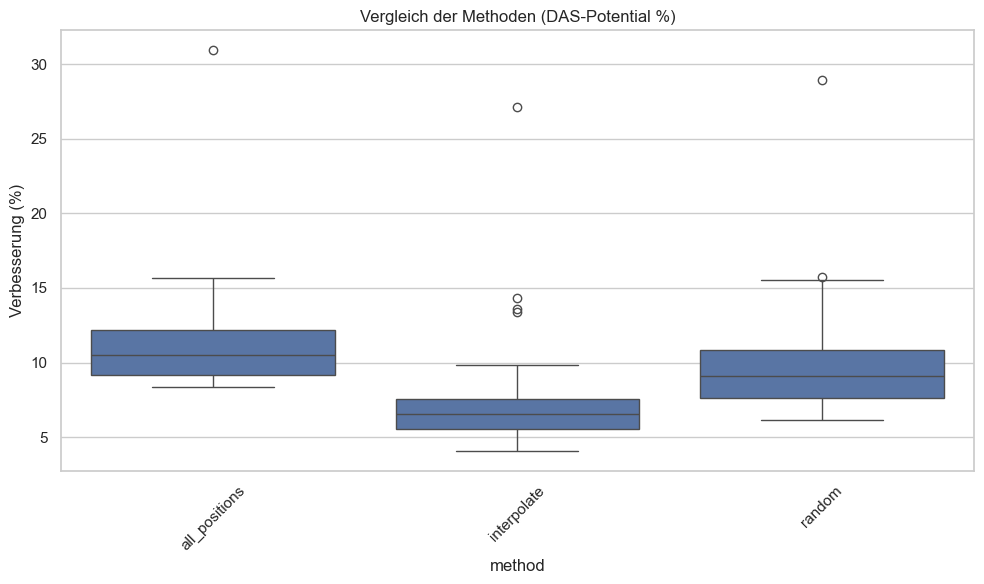

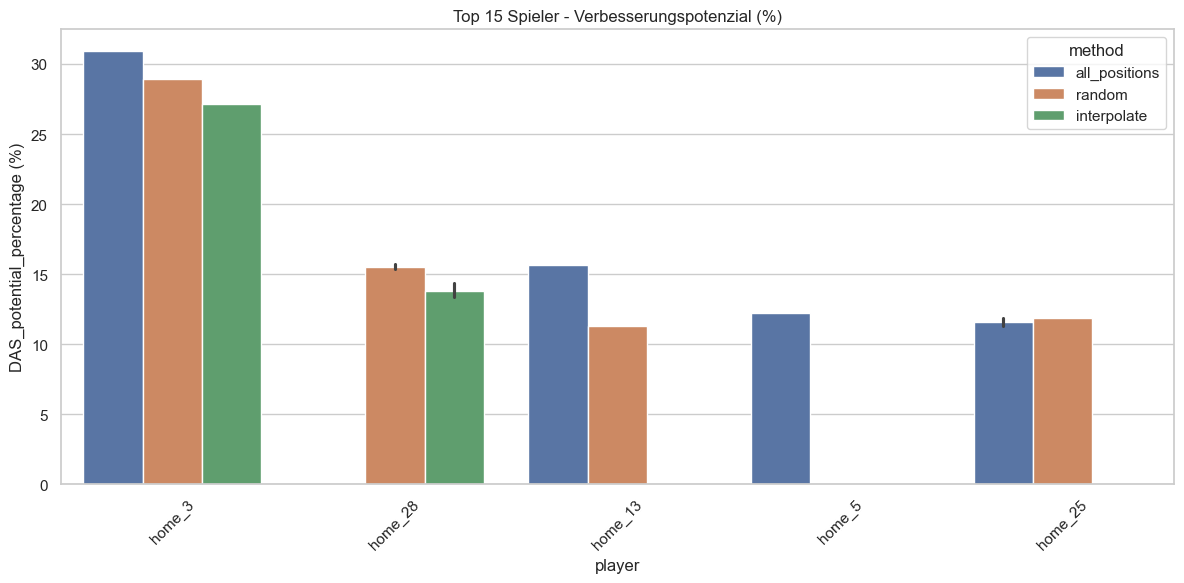

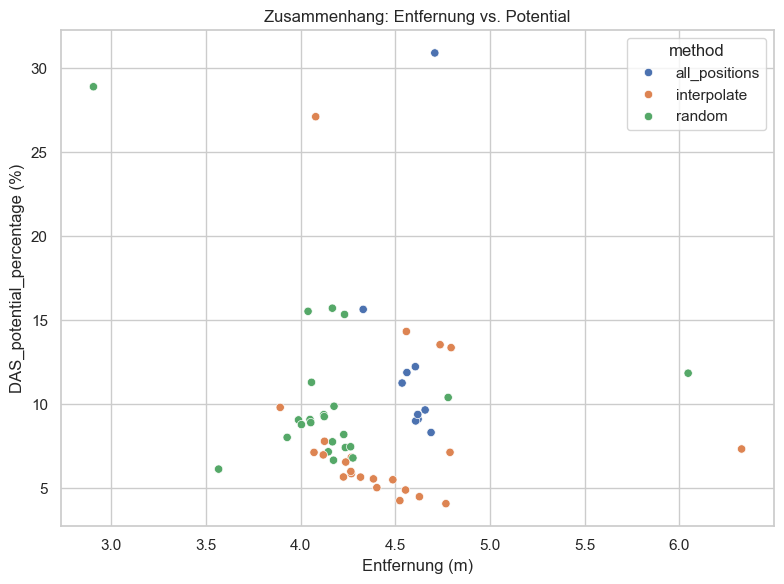

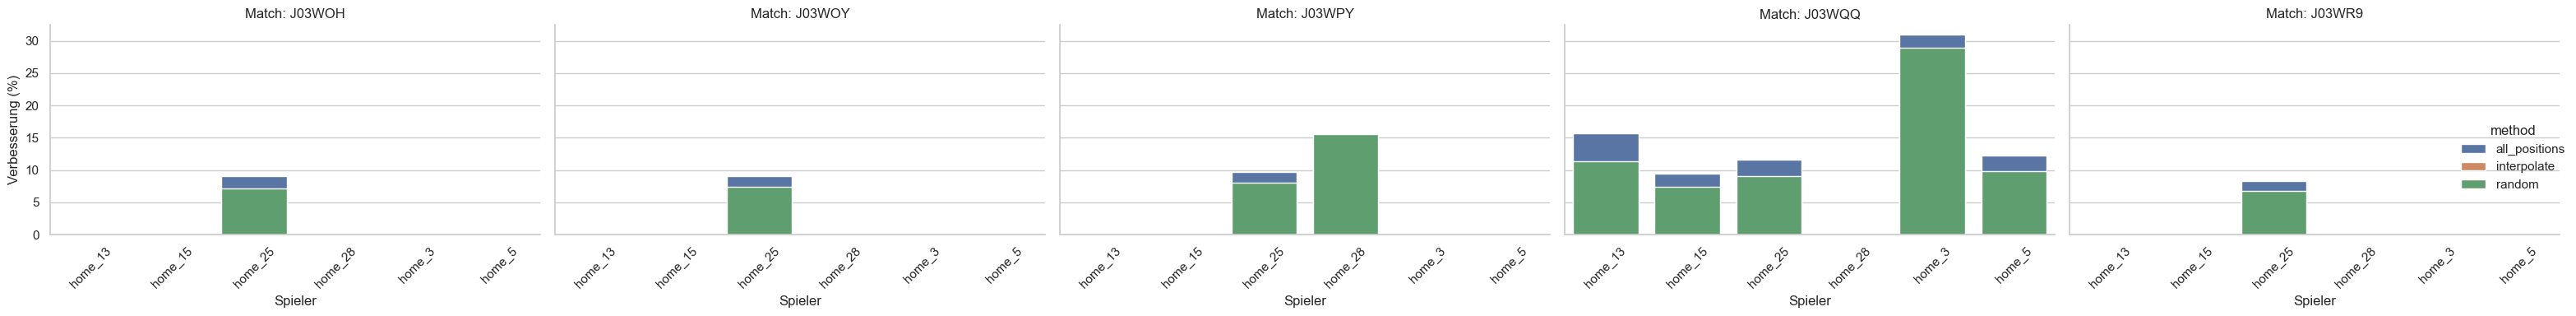

In [4]:
boxplot_methods(grouped_df)
bar_players(grouped_df)
scatter_dist_pot(grouped_df)
facet_grid(grouped_df)